<a href="https://colab.research.google.com/github/Oleksii-Adamov/rcpsp-qaoa/blob/main/RCPSP_QAOA_images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [1]:
!pip install pennylane

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 13.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.0/51.0 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.1/19.1 MB 41.3 MB/s eta 0:00:00


In [2]:
import pennylane as qml

In [3]:
import numpy as np
import matplotlib as plt
from matplotlib import pyplot as plt
from functools import partial
import networkx as nx
import pylab as pl
from matplotlib import collections  as mc

# Bell state (circuit example)

In [13]:
wires = range(0, 2)

In [14]:
dev = qml.device('default.qubit', wires=wires, shots=100)

In [15]:
@qml.qnode(dev)
def bell_state0():
    qml.Hadamard(wires=0)
    qml.CNOT(wires=[0, 1])
    return qml.counts(wires=wires)

In [16]:
counts = bell_state0()

In [17]:
counts

{'00': tensor(54, requires_grad=True), '11': tensor(46, requires_grad=True)}

In [18]:
qml.draw_mpl(bell_state0)

<function __main__.bell_state0()>

In [19]:
fig = qml.drawer.draw_mpl(bell_state0)

(<Figure size 500x300 with 1 Axes>, <Axes: >)

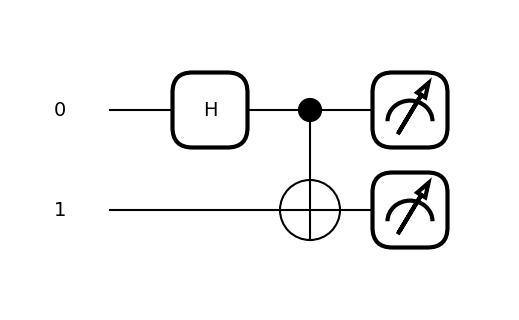

In [20]:
fig()

# QAOA circuit

In [21]:
# black and white style
plt.rcParams["savefig.facecolor"] = "white"
plt.rcParams["figure.facecolor"] = "white"
plt.rcParams["axes.facecolor"] = "white"
plt.rcParams["patch.facecolor"] = "white"
plt.rcParams["patch.edgecolor"] = "black"
plt.rcParams["patch.linewidth"] = 3.0
plt.rcParams["patch.force_edgecolor"] = True
plt.rcParams["lines.color"] = "black"
plt.rcParams["text.color"] = "black"
plt.rcParams["path.sketch"] = None
plt.rcParams["font.weight"] = "normal"
plt.rcParams["lines.linewidth"] = 1.5

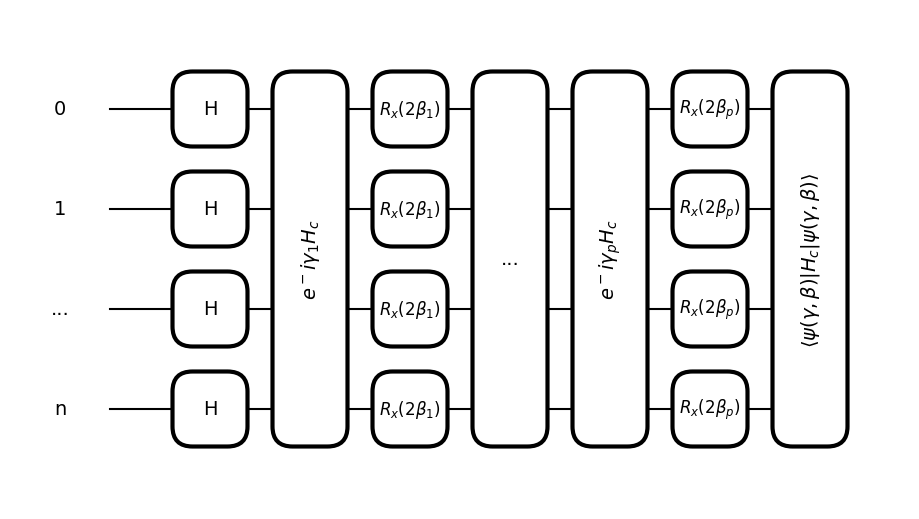

In [22]:
n_wires = 4
wires = range(0, n_wires)
drawer = qml.drawer.MPLDrawer(n_wires=n_wires, n_layers=6)
drawer.label(["0", "1", "...", "n"])
# Hadamards
for wire in range(0, n_wires):
    drawer.box_gate(layer=0, wires=wire, text="H")
# Cost layer
drawer.box_gate(layer=1, wires=wires, text= r"$e^-i\gamma_1 H_c$")
# Mixer layer
for wire in range(0, n_wires):
    drawer.box_gate(layer=2, wires=wire, text=r"$R_x(2\beta_1)$")
# dots layers
drawer.box_gate(layer=3, wires=wires, text= "...")
# Cost layer
drawer.box_gate(layer=4, wires=wires, text= r"$e^-i\gamma_p H_c$")
# Mixer layer
for wire in range(0, n_wires):
    drawer.box_gate(layer=5, wires=wire, text=r"$R_x(2\beta_p)$")
drawer.box_gate(layer=6, wires=wires, text= r"$\langle\psi(\gamma,\beta)|H_c|\psi(\gamma,\beta)\rangle$")

In [23]:
drawer.fig.savefig('qaoa.jpg')

# RCPSP visualisation

## Problem

In [56]:
real_num_activities = 3
T = 3
precedence_graph_edges = np.array([[1, 2], [1, 3]])
activity_processing_time = np.array([1, 1, 2])
resourse_capacity = np.array([3, 3])
resourse_consumption = np.array([[1, 2], [0, 2], [1, 1]])
number_of_recourses = resourse_capacity.shape[0]

## Problem visualization

In [57]:
def draw_rcpsp(num_activities, precedence_graph_edges, activity_processing_time, resourse_consumption, starting_activity=0):

    G = nx.from_edgelist(precedence_graph_edges, create_using=nx.DiGraph)

    for i in range(0, num_activities):
        if not G.has_node(i):
            G.add_node(i)

    pos=nx.bfs_layout(G, starting_activity)

    pos_higher = {}
    pos_lower = {}

    for k, v in pos.items():
        pos_higher[k] = (v[0], v[1]+0.05)
        pos_lower[k] = (v[0], v[1]-0.05)

    duration_labels_dict = {}
    for i in range(0, num_activities):
        duration_labels_dict[i] = str(activity_processing_time[i])

    resource_labels_dict = {}
    for i in range(0, num_activities):
        label = ""
        for k in range(0, resourse_consumption.shape[1]):
            label = label + str(resourse_consumption[i, k])
            if k < resourse_consumption.shape[1] - 1:
                label = label + ", "
        resource_labels_dict[i] = label

    nx.draw(G, pos, with_labels=True)
    nx.draw_networkx_labels(G, pos_higher, duration_labels_dict)
    nx.draw_networkx_labels(G, pos_lower, resource_labels_dict)

## Visualize with dummy activities

In [58]:
def add_dummy_activities(real_num_activities, precedence_graph_edges, activity_processing_time, resourse_consumption):
    num_activities = real_num_activities + 2
    has_outcoming = [False] * (real_num_activities+1)
    has_incoming = [False] * (real_num_activities+1)
    for edge in precedence_graph_edges:
        has_outcoming[int(edge[0])] = True
        has_incoming[int(edge[1])] = True

    # add to graph
    for i in range(1, real_num_activities+1):
        if not has_outcoming[i]:
            precedence_graph_edges = np.concatenate([precedence_graph_edges, [[i, real_num_activities+1]]])
        if not has_incoming[i]:
            precedence_graph_edges = np.concatenate([precedence_graph_edges, [[0, i]]])
    # add processing time
    activity_processing_time = np.concatenate([[0], activity_processing_time, [0]])
    # add to resources 0 consumption
    resourse_consumption = np.concatenate([[[0] * number_of_recourses], resourse_consumption, [[0] * number_of_recourses]])
    return num_activities, precedence_graph_edges, activity_processing_time, resourse_consumption

In [59]:
num_activities_d, precedence_graph_edges_d, activity_processing_time_d, resourse_consumption_d = add_dummy_activities(real_num_activities, precedence_graph_edges, activity_processing_time, resourse_consumption)

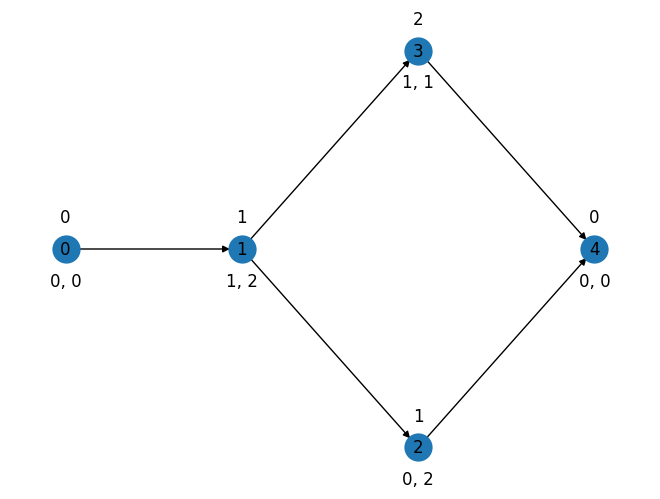

In [60]:
draw_rcpsp(num_activities_d, precedence_graph_edges_d, activity_processing_time_d, resourse_consumption_d)

## Visualize solution

### Preparing

In [61]:
def add_smart_dummy_activities_no_start(real_num_activities, precedence_graph_edges, activity_processing_time, resourse_consumption):
    num_activities = real_num_activities
    starting_activity = None
    end_activity = None

    has_outcoming = [False] * (real_num_activities+1)
    has_incoming = [False] * (real_num_activities+1)
    for edge in precedence_graph_edges:
        has_outcoming[int(edge[0])] = True
        has_incoming[int(edge[1])] = True
    # mark 0 index True, so it won't be counted
    has_incoming[0] = True
    has_outcoming[0] = True
    to_insert_start_activity = has_incoming.count(False) > 1
    to_insert_end_activity = has_outcoming.count(False) > 1
    for i in range(1, real_num_activities+1):
        if to_insert_end_activity and not has_outcoming[i]:
            precedence_graph_edges = np.concatenate([precedence_graph_edges, [[i, real_num_activities+1]]])
        if not to_insert_start_activity and not has_incoming[i]:
            starting_activity = i
        if not to_insert_end_activity and not has_outcoming[i]:
            end_activity = i

    if to_insert_end_activity:
        print("inserted end activity")
        num_activities += 1
        activity_processing_time = np.concatenate([activity_processing_time, [0]])
        resourse_consumption = np.concatenate([resourse_consumption, [[0] * number_of_recourses]])
        end_activity = real_num_activities+1

    # shift numeration to be from zero
    if not starting_activity is None:
        starting_activity -= 1
    end_activity -= 1
    for edge in precedence_graph_edges:
        edge[0] -= 1
        edge[1] -= 1

    return num_activities, precedence_graph_edges, activity_processing_time, resourse_consumption, starting_activity, end_activity

In [62]:
num_activities, precedence_graph_edges, activity_processing_time, resourse_consumption, starting_activity, end_activity = add_smart_dummy_activities_no_start(real_num_activities, precedence_graph_edges, activity_processing_time, resourse_consumption)

inserted end activity


In [63]:
def longest_paths_in_postive_graph(G, weigth_func):
    # find shortest path for -G, O(V+E)
    topological_order = list(nx.topological_sort(G)) # Kahn's algorithm (incoming degrees), O(V+E)
    # all incoming weights are non-negative, because of reverse sign of weights, zero weight path is max
    shortest_path = np.full_like(activity_processing_time, 0)
    for node in topological_order:
        for neighbor in G[node]:
            if not neighbor is None and shortest_path[neighbor] > shortest_path[node] - weigth_func(node, neighbor):
                shortest_path[neighbor] = shortest_path[node] - weigth_func(node, neighbor)
    return -shortest_path

def calculate_time_windows(precedence_graph_edges, end_activity):
    # calculate earliest start
    # by finding longest paths from source (start activity) to every node, weights - activity processing time
    precedence_graph_edges_with_start_activity = np.copy(precedence_graph_edges)
    if starting_activity is None:
        precedence_graph_edges_with_start_activity = np.concatenate([[np.array([-1, i]) for i in range(0, num_activities)], precedence_graph_edges_with_start_activity])
    G = nx.from_edgelist(precedence_graph_edges_with_start_activity, create_using=nx.DiGraph)
    nx.draw(G, with_labels=True)
    earliest_start = longest_paths_in_postive_graph(G, lambda u, v: activity_processing_time[u] if u > -1 else 0)
    # calculate latest start
    latest_start = np.full_like(activity_processing_time, 0)
    for activity in range(0, num_activities):
        descendants = nx.descendants(G, activity)
        for activity2 in range(0, num_activities):
            if not (activity2 in descendants):
                latest_start[activity] += activity_processing_time[activity2]
        latest_start[activity] = min(T, latest_start[activity])
    return earliest_start, latest_start

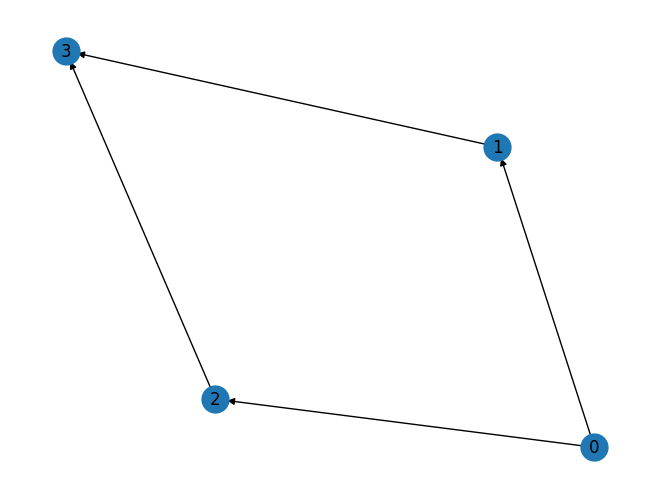

In [64]:
earliest_start, latest_start = calculate_time_windows(precedence_graph_edges, end_activity)

In [65]:
activity_time_index_start = np.empty_like(activity_processing_time)
cur_index = 0
for i in range(0, num_activities):
    activity_time_index_start[i] = cur_index
    cur_index += latest_start[i] - earliest_start[i] + 1

In [66]:
def activity_time_to_index(activity_index, time_index):
    assert(time_index >= earliest_start[activity_index] and time_index <= latest_start[activity_index])
    return activity_time_index_start[activity_index] + time_index - earliest_start[activity_index]

In [67]:
def from_index_to_activity_time(index):
    for i in range(0, num_activities):
        if index >= activity_time_index_start[i] and index <= activity_time_index_start[i] + latest_start[i] - earliest_start[i]:
            return i, earliest_start[i] + index - activity_time_index_start[i]

### Solution visulization

In [68]:
def visualize_solution(x, offset_activity_num=0):
    fig, ax = pl.subplots()
    lines = []
    for i in range(0, x.shape[0]):
        if x[i] == 1:
            activity, time = from_index_to_activity_time(i)
            print(i, activity, time)
            if activity_processing_time[activity] > 0:
                lines.append([(time, activity), (time + activity_processing_time[activity], activity)])
                ax.text(time + activity_processing_time[activity] / 2, activity + 0.1, f'{activity + offset_activity_num}')

    lc = mc.LineCollection(lines, linewidths=2)
    ax.add_collection(lc)
    ax.set_xlabel('час', fontsize=18)
    ax.set_ylabel('дія', fontsize=18)
    ax.autoscale()
    ax.margins(0.1)

In [70]:
opt_x = np.array([1, 0, 1, 0, 0, 1, 0, 0, 1])

0 0 0
2 1 1
5 2 1
8 3 3


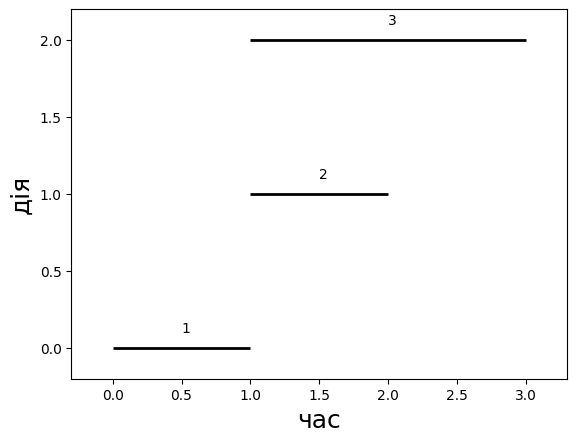

In [71]:
visualize_solution(opt_x, 1)